In [235]:
import numpy as np
import pandas
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve

#
Linear Regression

In [248]:
#Code block pasted from https://pantelis.github.io/aiml-common/lectures/regression/linear-regression/

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

In [266]:
x_train, y_train = create_toy_data(sinusoidal, 100, 0.25)

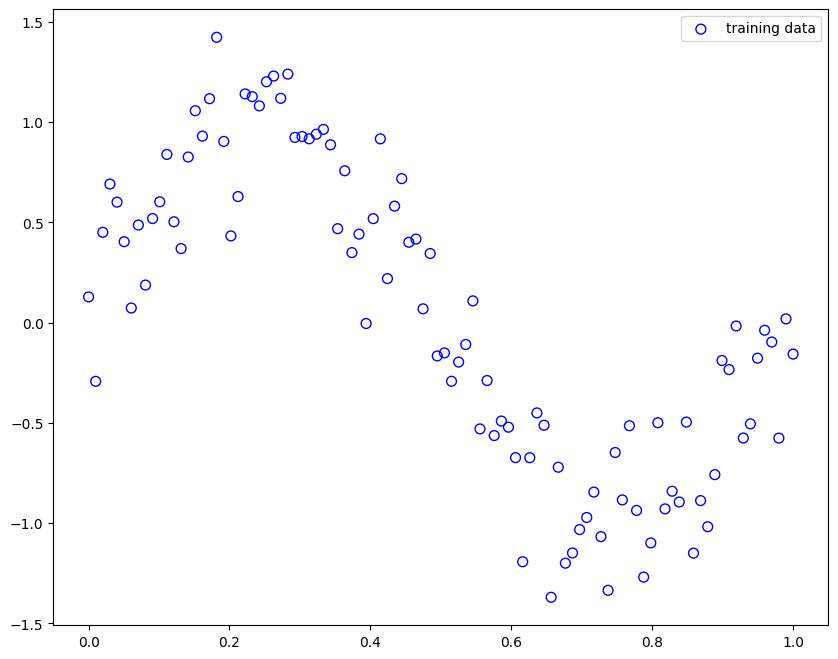

In [267]:
plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.legend()
plt.show()

In [268]:
#Convert x_train, y_train to tensors

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

In [264]:
#Function to train a polynomial regression model

def reg(x_train, y_train, eta, epochs, alpha, beta, order, method='SGD'):
    
    #Initializing weights and bias
    w = torch.randn(order, requires_grad=False)  
    b = torch.randn(1, requires_grad=False)      

    #Reading in hyperparameters
    learning_rate = eta
    num_epochs = epochs
    lambda_reg = alpha  

    #Initializing velocity 
    v_w = torch.zeros_like(w)  
    v_b = torch.zeros_like(b)  

    #List to store losses 
    loss_history = []

    #Variables to store best_loss and associated epoch
    best_loss = float('inf')  
    best_epoch = 0  

    #Training loop for each epoch over every training example
    for epoch in range(num_epochs):
        for i in range(len(x_train)): 
            x_i = x_train[i]  
            y_i = y_train[i]  

            #Forward pass
            y_pred = sum([w[j] * x_i**(j + 1) for j in range(order)]) + b

            #Computing MSE
            mse_loss = (y_i - y_pred) ** 2
            #L2 norm term
            l2_reg = lambda_reg * (w ** 2).sum()
            #Total loss per instance
            loss = mse_loss + l2_reg

            #Computing gradients
            grad_w = torch.zeros_like(w)
            #For each wi
            for j in range(order):
                grad_w[j] = -2 * (y_i - y_pred) * (x_i ** (j + 1)) - 2 * lambda_reg * w[j]
            #For bias term 
            grad_b = -2 * (y_i - y_pred) 

            #Updating velocities
            v_w = beta * v_w + (1 - beta) * grad_w
            v_b = beta * v_b + (1 - beta) * grad_b

            #Updating weights for SGD 
            if method == 'SGD':
                w -= learning_rate * grad_w
                b -= learning_rate * grad_b

            #Updating weights for SGD with momentum
            elif method == 'momentum':
                w -= learning_rate * v_w
                b -= learning_rate * v_b

        #Storing mean loss for epoch
        avg_loss = torch.mean(loss)
        loss_history.append(avg_loss.item())

        #Storing best loss and associated epoch 
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch 

    #Plotting Loss vs. Epoch
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    #Plotting training samples
    plt.scatter(x_train.numpy(), y_train.numpy(), label='Data Points')

    y_pred_final = sum([w[i] * x_train**(i + 1) for i in range(order)]) + b
    #Plotting final hypothesis
    plt.scatter(x_train.numpy(), y_pred_final.detach().numpy(), color='red', label=f'Fitted {order}th Degree Polynomial')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Final Hypothesis ({order}th Order Polynomial)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Final Hypothesis: y = {" + ".join([f"{w[i].item():.4f} * x^{i + 1}" for i in range(order)])} + {b.item():.4f}')
    print(f'Final Loss: {best_loss:.4f} at Epoch: {best_epoch}')
    print('---------------------------------------------------------------------------------------------\n')


For SGD without momentum:



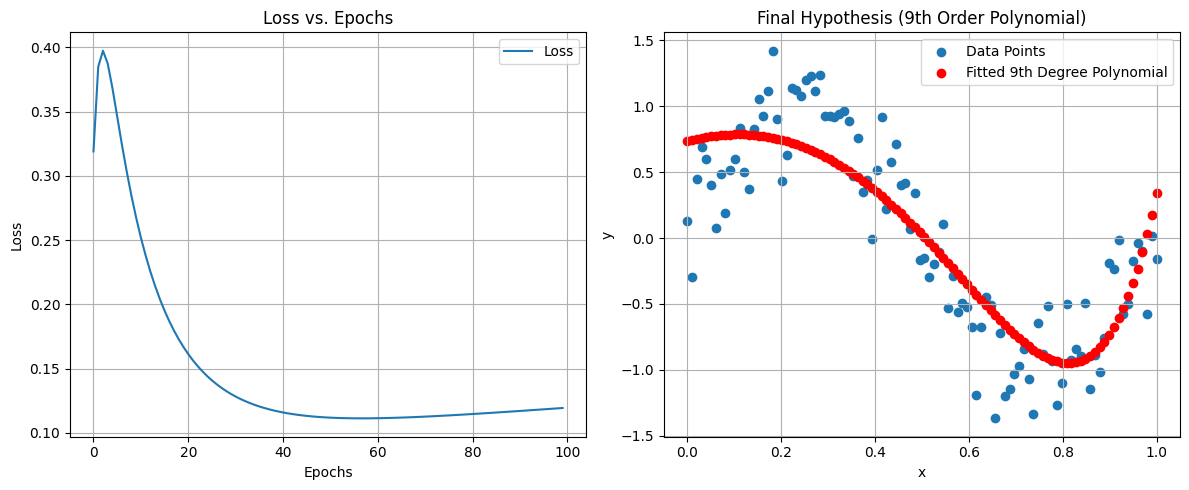

Final Hypothesis: y = 0.8859 * x^1 + -3.7365 * x^2 + -2.4973 * x^3 + -0.2862 * x^4 + 2.6041 * x^5 + 1.9044 * x^6 + -1.2837 * x^7 + 1.1907 * x^8 + 0.8242 * x^9 + 0.7381
Final Loss: 0.1113 at Epoch: 57
---------------------------------------------------------------------------------------------



In [274]:
#Training SGD without momentum using learning_rate = 0.01, lambda = 0.001 for a 9th order polynomial for 100 epochs
print("For SGD without momentum:\n")
reg(x_train,y_train,eta=0.01,epochs=100,alpha=0.001,beta=0.9,order=9,method='SGD')


For SGD with momentum:



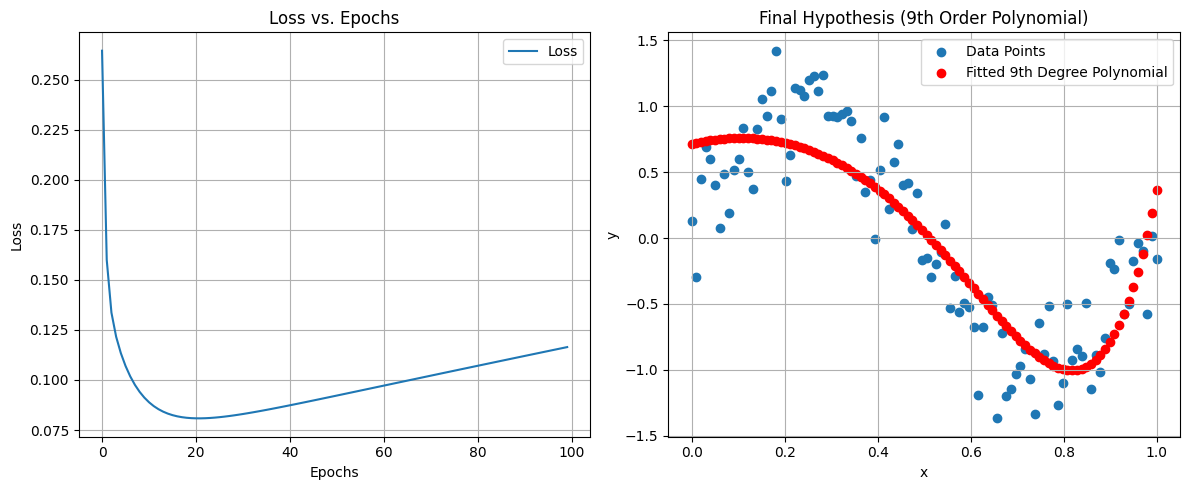

Final Hypothesis: y = 0.8410 * x^1 + -3.8106 * x^2 + -0.2684 * x^3 + -2.7594 * x^4 + 0.6106 * x^5 + 1.9449 * x^6 + 1.8847 * x^7 + 1.6384 * x^8 + -0.4279 * x^9 + 0.7136
Final Loss: 0.0808 at Epoch: 21
---------------------------------------------------------------------------------------------



In [278]:
#Training SGD with momentum using learning_rate = 0.02, lambda = 0.001, beta(momentum coefficient) = 0.9 for a 9th order polynomial for 100 epochs
print("For SGD with momentum:\n")
reg(x_train,y_train,eta=0.02,epochs=100,alpha=0.001,beta=0.9,order=9,method='momentum')

SGD without Momentum weight updates

\begin{align*}
    \text{mse\_loss} &= (y_i - y_{\text{pred}})^2 \\
    \text{l2\_reg} &= \lambda_{\text{reg}} \cdot \sum w^2 \\  % L2 regularization term
    \text{loss} &= \text{mse\_loss} + \text{l2\_reg} \\

    % Manually compute gradients
    \text{grad\_w} &= \mathbf{0}_{\text{like}}(w) \\ 
    \text{for } j &= 0 \text{ to } \text{order} - 1: \\
    \quad \text{grad\_w}[j] &= -2 \cdot (y_i - y_{\text{pred}}) \cdot (x_i^{(j + 1)}) - 2 \cdot \lambda_{\text{reg}} \cdot w[j] \\ 
    \text{grad\_b} &= -2 \cdot (y_i - y_{\text{pred}}) \\

    % Update weights for SGD
    w &\leftarrow w - \text{learning\_rate} \cdot \text{grad\_w} \\
    b &\leftarrow b - \text{learning\_rate} \cdot \text{grad\_b}
\end{align*}




SGD with Momentum weight updates

\begin{align*}
    \text{mse\_loss} &= (y_i - y_{\text{pred}})^2 \\
    \text{l2\_reg} &= \lambda_{\text{reg}} \cdot \sum w^2 \\  % L2 regularization term
    \text{loss} &= \text{mse\_loss} + \text{l2\_reg} \\

    % Manually compute gradients
    \text{grad\_w} &= \mathbf{0}_{\text{like}}(w) \\ 
    \text{for } j &= 0 \text{ to } \text{order} - 1: \\
    \quad \text{grad\_w}[j] &= -2 \cdot (y_i - y_{\text{pred}}) \cdot (x_i^{(j + 1)}) - 2 \cdot \lambda_{\text{reg}} \cdot w[j] \\ 
    \text{grad\_b} &= -2 \cdot (y_i - y_{\text{pred}}) \\

    % Update velocities for momentum
    v_w &= \beta \cdot v_w + (1 - \beta) \cdot \text{grad\_w} \\
    v_b &= \beta \cdot v_b + (1 - \beta) \cdot \text{grad\_b} \\

    % Update weights for momentum
    w &\leftarrow w - \text{learning\_rate} \cdot v_w \\
    b &\leftarrow b - \text{learning\_rate} \cdot v_b
\end{align*}


Observations : 
1. SGD with momentum achieves a better loss than SGD without momentum which is as expected. 
2. SGD with momentum is generally faster for a complex hypothesis.

#
Data Exploration

In [2]:
#Read the original dataser
df = pandas.read_csv("D:\MS 2024\AI_fall2024\\assignment1b\LogRegData\\train.csv")

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\acer\AppData\Local\Temp\ipykernel_6948\2895353340.py:1: SyntaxWarning: invalid escape sequence '\M'
  df = pandas.read_csv("D:\MS 2024\AI_fall2024\\assignment1b\LogRegData\\train.csv")


In [3]:
df_click_0 = df[df['click'] == 0]
df_click_1 = df[df['click'] == 1]

# Sampled train set
# 30000 click and 30000 non-click
train_click_0 = df_click_0.sample(n=30000, random_state=42)
train_click_1 = df_click_1.sample(n=30000, random_state=42)
train = pandas.concat([train_click_0, train_click_1]).sample(frac=1, random_state=42)

# Sampled test set
# 2000 click and 8000 non-click
test_click_0 = df_click_0.sample(n=8000, random_state=42)
test_click_1 = df_click_1.sample(n=2000, random_state=42)
test = pandas.concat([test_click_0, test_click_1]).sample(frac=1, random_state=42)  # Shuffle the combined set


print(test['click'].value_counts(normalize=True))
print(train['click'].value_counts(normalize=True))


click
0    0.8
1    0.2
Name: proportion, dtype: float64
click
0    0.5
1    0.5
Name: proportion, dtype: float64


In [4]:
print(train.shape)
print(test.shape)

(60000, 24)
(10000, 24)


In [156]:
#Saving sampled train and test sets for easy loading
train = pandas.read_csv("D:\MS 2024\AI_fall2024\\assignment1b\Sampled_data\\train_data.csv")
test = pandas.read_csv("D:\MS 2024\AI_fall2024\\assignment1b\Sampled_data\\test_data.csv")

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\acer\AppData\Local\Temp\ipykernel_19568\2364940925.py:1: SyntaxWarning: invalid escape sequence '\M'
  train = pandas.read_csv("D:\MS 2024\AI_fall2024\\assignment1b\Sampled_data\\train_data.csv")
C:\Users\acer\AppData\Local\Temp\ipykernel_19568\2364940925.py:2: SyntaxWarning: invalid escape sequence '\M'
  test = pandas.read_csv("D:\MS 2024\AI_fall2024\\assignment1b\Sampled_data\\test_data.csv")


In [109]:
train.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.376438e+18,0,14102919,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,22765,320,50,2640,3,35,-1,23
1,1.496615e+19,1,14102204,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,...,1,0,6563,320,50,572,2,39,-1,32
2,1.440433e+19,1,14102802,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17014,320,50,1872,3,39,-1,23
3,1.077371e+19,0,14102815,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,23164,320,50,2668,0,35,-1,221
4,1.535540e+19,0,14102508,1005,1,a7853007,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,22288,320,50,2572,3,297,100156,42


In [108]:
test.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2.259006e+18,0,14103004,1005,0,85f751fd,c4e18dd6,50e219e0,c8e3e3c1,b5f3b24a,...,1,2,22937,320,50,2653,0,47,-1,94
1,1.745601e+19,0,14103015,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,...,1,0,23726,320,50,2717,2,47,-1,23
2,2.488835e+18,0,14102805,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,1,0,22683,320,50,2528,0,39,100081,221
3,1.395597e+19,0,14102807,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,20108,320,50,2299,2,1327,100084,52
4,1.971229e+18,0,14103004,1005,0,85f751fd,c4e18dd6,50e219e0,521b316b,2347f47a,...,1,2,23804,320,50,2726,3,803,-1,229


In [5]:
#Checking col types in train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                60000 non-null  float64
 1   click             60000 non-null  int64  
 2   hour              60000 non-null  int64  
 3   C1                60000 non-null  int64  
 4   banner_pos        60000 non-null  int64  
 5   site_id           60000 non-null  object 
 6   site_domain       60000 non-null  object 
 7   site_category     60000 non-null  object 
 8   app_id            60000 non-null  object 
 9   app_domain        60000 non-null  object 
 10  app_category      60000 non-null  object 
 11  device_id         60000 non-null  object 
 12  device_ip         60000 non-null  object 
 13  device_model      60000 non-null  object 
 14  device_type       60000 non-null  int64  
 15  device_conn_type  60000 non-null  int64  
 16  C14               60000 non-null  int64 

In [6]:
train.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,6.000000e+04,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,9.206454e+18,0.500000,1.410256e+07,1004.933050,0.302783,0.998183,0.269833,18565.008667,318.296200,65.822800,2080.296417,1.460283,226.394783,50537.929783,78.741267
std,5.331297e+18,0.500004,2.951941e+02,1.075726,0.533583,0.497076,0.768808,5048.264439,20.161272,57.436351,619.989468,1.304486,360.202732,50053.154617,69.170248
min,4.073366e+14,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,4.581834e+18,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16687.000000,320.000000,50.000000,1800.000000,0.000000,35.000000,-1.000000,23.000000
50%,9.159053e+18,0.500000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20108.000000,320.000000,50.000000,2295.000000,2.000000,39.000000,100003.000000,51.000000
75%,1.383980e+19,1.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21834.000000,320.000000,50.000000,2513.000000,3.000000,169.000000,100084.000000,79.000000
max,1.844666e+19,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24042.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000


In [7]:
#Checking for missing values in train and test sampled dataframes

missing_values = train.isna().sum()
print("Missing in Train: ", missing_values)

missing_values_2 = test.isna().sum()
print("Missing in Test: ", missing_values_2)

Missing in Train:  id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64
Missing in Test:  id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17 

In [8]:
#Checking train dataframe for cardinality of each column

for category in train.columns:
    num_unique_categories = train[category].nunique()
    print(category, num_unique_categories)


id 60000
click 2
hour 240
C1 7
banner_pos 7
site_id 1213
site_domain 1068
site_category 16
app_id 991
app_domain 63
app_category 22
device_id 9610
device_ip 48652
device_model 2729
device_type 4
device_conn_type 4
C14 1532
C15 8
C16 9
C17 390
C18 4
C19 63
C20 151
C21 60


In [157]:
#Label encoding all columns as they are categorical in nature by definition

label_encoder = LabelEncoder()

for col in train.columns:
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])
    test[col] = label_encoder.transform(test[col])

In [158]:
#Scaling the label encoded column data to fit mean=0 and variance=1 due to high cardinality in a significant number of columns

scaler = StandardScaler()

train = pandas.DataFrame(scaler.fit_transform(train), columns=train.columns)
test = pandas.DataFrame(scaler.transform(test), columns=test.columns)

In [159]:
train.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,-1.093242,-1.0,1.297446,-0.014594,-0.585408,0.199597,0.495046,-0.386757,0.287404,-0.594863,...,0.134536,-0.336181,1.451233,0.284241,-0.265616,1.536395,1.180334,-0.655052,-0.870174,-0.833092
1,1.079212,1.0,-1.269163,-0.014594,1.358392,-1.536094,-2.484523,1.368955,0.484151,0.147331,...,0.134536,-0.336181,-1.129351,0.284241,-0.265616,-1.275122,0.413742,-0.526972,-0.870174,-0.775016
2,0.970786,1.0,0.722414,-0.014594,1.358392,1.532763,-0.690662,1.368955,0.484151,0.147331,...,0.134536,-0.336181,-0.771351,0.284241,-0.265616,-0.809768,1.180334,-0.526972,-0.870174,-0.833092
3,0.292745,-1.0,0.904741,-0.014594,-0.585408,-1.413726,1.191171,-1.167074,0.484151,0.147331,...,0.134536,-0.336181,1.888788,0.284241,-0.265616,1.798157,-1.119441,-0.655052,-0.870174,1.954555
4,1.151265,-1.0,-0.203249,-0.014594,1.358392,0.695509,-0.690662,1.368955,0.484151,0.147331,...,0.134536,-0.336181,1.028594,0.284241,-0.265616,1.061346,1.180334,0.433631,1.529927,-0.600788


In [143]:
#Calculating mutual information between each column and the target column (click) and sorting in descending order

mi_scores = mutual_info_classif(train.drop(columns=['click']), train['click'], discrete_features=True)

mi = pandas.DataFrame(mi_scores, index=train.drop(columns=['click']).columns, columns=['Mutual Information with click'])
mi.sort_values(by='Mutual Information with click', ascending=False)

d:\conda\envs\AI1b\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
d:\conda\envs\AI1b\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
d:\conda\envs\AI1b\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
d:\conda\envs\AI1b\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
d:\conda\envs\AI1b\Lib\site-packages

,Mutual Information with click
id,0.693147
device_ip,0.570262
device_id,0.112866
C14,0.079646
site_id,0.072762
site_domain,0.065037
C17,0.064536
device_model,0.061472
app_id,0.052505
C21,0.041083


In [160]:
#Dropping id and device_ip due to mutual_info > 0.5 and high variance in values
#Dropping hour, C1, device_type and banner_pos due to mutual_info < 0.01

train = train.drop(columns=['id','device_ip','hour','C1','device_type','banner_pos'])
test = test.drop(columns=['id','device_ip','hour','C1','device_type','banner_pos'])

In [161]:
#Seperating features and target for train set

X = train.drop(['click'], axis=1)  
y = train['click']  

In [162]:
print(X.shape)
print(y.shape)

(60000, 17)
(60000,)


In [163]:
#Seperating features and target for test set

x_test_df = test.drop(['click'], axis=1)
y_test_df = test['click'] 

print(x_test_df.shape)
print(y_test_df.shape)

(10000, 17)
(10000,)


#
Logistic Regression

In [164]:
#Converting all df type variables to tensors 

x_train = torch.tensor(X.values, dtype=torch.float32)
y_train = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

x_test = torch.tensor(x_test_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


torch.Size([60000, 17]) torch.Size([60000, 1])
torch.Size([10000, 17]) torch.Size([10000, 1])


In [165]:
#Converting target variable to 0/1 to fit into a logistic regression function

y_train = torch.where(y_train == -1, torch.tensor(0), y_train)
unique_values, counts = torch.unique(y_train, return_counts=True)

print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: tensor([0., 1.])
Counts: tensor([30000, 30000])


In [166]:
#Converting target variable to 0/1 to fit into a logistic regression function

y_test = torch.where(y_test == -1, torch.tensor(0), y_test)
unique_values, counts = torch.unique(y_test, return_counts=True)

print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: tensor([0., 1.])
Counts: tensor([8000, 2000])


In [16]:
#A function to plot training loss and validation loss vs epoch on the same plot

def plot(train_losses, val_losses):
    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label='Training Loss', color='blue')
    
    val_epochs = len(val_losses)
    
    plt.plot(range(0, val_epochs * len(train_losses) // val_epochs, len(train_losses) // val_epochs), 
             val_losses, label='Validation Loss', linestyle='--', color='orange')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [222]:
#Function to train a logistic regression model and track training and testing loss 

def logreg(x_train, y_train, x_test, y_test, eta=0.01, epochs=100, lamda=1):
    
    dim = x_train.shape[1]
    
    #Initialization of weights and bias to small positive values
    w = torch.randn((dim, 1), dtype=torch.float32) * 0.01  
    b = torch.randn(1, dtype=torch.float32) * 0.01  

    #List to store train losses
    train_losses = []

    #List to store val losses
    val_losses = []

    #Variables to store best losses, weights and bias
    min_train_loss , min_val_loss, best_b = 10,10,0
    best_w = torch.zeros((dim, 1), dtype=torch.float32)

    #Small positive number to avoid log(0) and log(1)
    epsilon = 1e-7 

    for epoch in range(epochs):
        #Forward pass
        linear_combination = torch.matmul(x_train, w) + b
        #Sigmoid function
        sig = 1 / (1 + torch.exp(-linear_combination))
        #Clamping sigmoid using epsilon to avoid log(0) and log(1)
        sig = torch.clamp(sig, min=epsilon, max=1 - epsilon)

        #BCE loss term 
        bce = - (y_train * torch.log(sig) + (1 - y_train) * torch.log(1 - sig))
        #L2 norm term 
        l2 = lamda * torch.sum(w.pow(2))
        #Average loss for epoch   
        loss = bce.mean() + l2  

        #Backward pass
        #Gradient of loss w.r.t weights
        error = sig - y_train 
        dW = torch.matmul(x_train.T, error) / x_train.size(0) + 2 * lamda * w  
        #Gradient of loss w.r.t bias
        dB = error.mean()  

        #Weights and bias update
        w -= eta * dW
        b -= eta * dB

        #Saving epoch loss
        train_losses.append(loss.item())

        #Calculating Val loss per epoch
        with torch.no_grad(): 
            #Forward pass
            linear_combination_test = torch.matmul(x_test, w) + b
            sig_test = 1 / (1 + torch.exp(-linear_combination_test))
            sig_test = torch.clamp(sig_test, min=epsilon, max=1 - epsilon)

            #Average val loss for epoch
            bce_val = -torch.mean(y_test * torch.log(sig_test) + (1 - y_test) * torch.log(1 - sig_test))
            l2_val = lamda * torch.sum(w.pow(2))
            val_loss = bce_val + l2_val
            val_losses.append(val_loss.item())

        #Saving best parametres for minimum val_loss
        if val_loss.item() < min_val_loss:
            min_train_loss = loss
            min_val_loss = val_loss.item()
            best_w = w
            best_b = b

    print(f"Best training loss: {min_train_loss:.4f}, Best val loss: {min_val_loss:.4f}")

    return best_w,best_b,train_losses,val_losses



\begin{align*}
    \text{bce} &= - \left( y_{\text{train}} \cdot \log(\text{sig}) + (1 - y_{\text{train}}) \cdot \log(1 - \text{sig}) \right) \\
    % L2 norm term 
    \text{l2} &= \lambda \cdot \sum w^2 \\
    % Average loss for epoch   
    \text{loss} &= \frac{1}{N} \sum \text{bce} + \text{l2}  \\

    % Backward pass
    % Gradient of loss w.r.t weights
    \text{error} &= \text{sig} - y_{\text{train}} \\ 
    dW &= \frac{1}{N} \cdot (x_{\text{train}}^T \cdot \text{error}) + 2 \cdot \lambda \cdot w \\  
    % Gradient of loss w.r.t bias
    dB &= \text{mean}(\text{error}) \\

    % Weights and bias update
    w &\leftarrow w - \eta \cdot dW \\
    b &\leftarrow b - \eta \cdot dB
\end{align*}


In [225]:
#Function to evaluate model performance on val data

def evaluate_model(x_test, y_test, w, b):
    epsilon = 1e-7
    #Forward pass
    with torch.no_grad():
        linear_combination_test = torch.matmul(x_test, w) + b
        sig_test = 1 / (1 + torch.exp(-linear_combination_test))
        sig_test = torch.clamp(sig_test, min=epsilon, max=1 - epsilon)

        #Convert probabilities to 0/1
        preds_test = (sig_test >= 0.5).float()

    
    y_test_np = y_test.numpy()
    preds_test_np = preds_test.numpy()

    #Computing metrics using sklearn
    accuracy = accuracy_score(y_test_np, preds_test_np)
    precision = precision_score(y_test_np, preds_test_np)
    recall = recall_score(y_test_np, preds_test_np)
    f1 = f1_score(y_test_np, preds_test_np)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    precision_values, recall_values = precision_recall_curve(y_test_np, sig_test.numpy())

    #Plotting the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall_values, precision_values, marker='.', label='Precision-Recall curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.legend()
    plt.show()

Best training loss: 0.6880, Best val loss: 0.6892


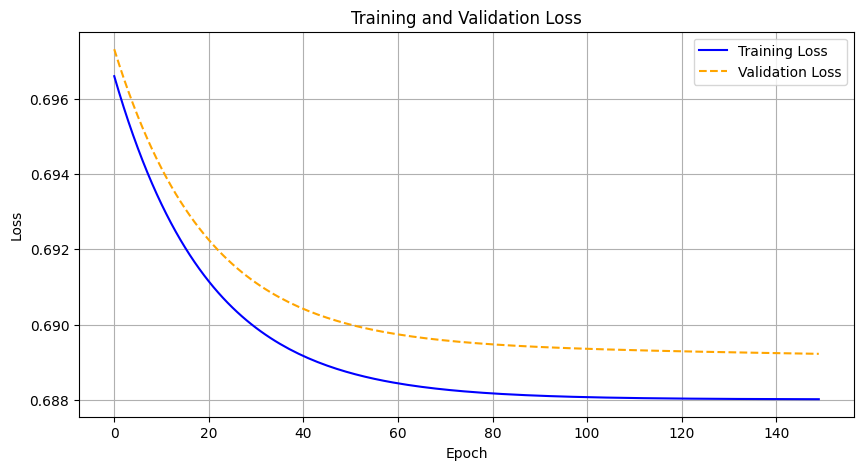

Accuracy: 0.5431
Precision: 0.2437
Recall: 0.6105
F1 Score: 0.3483


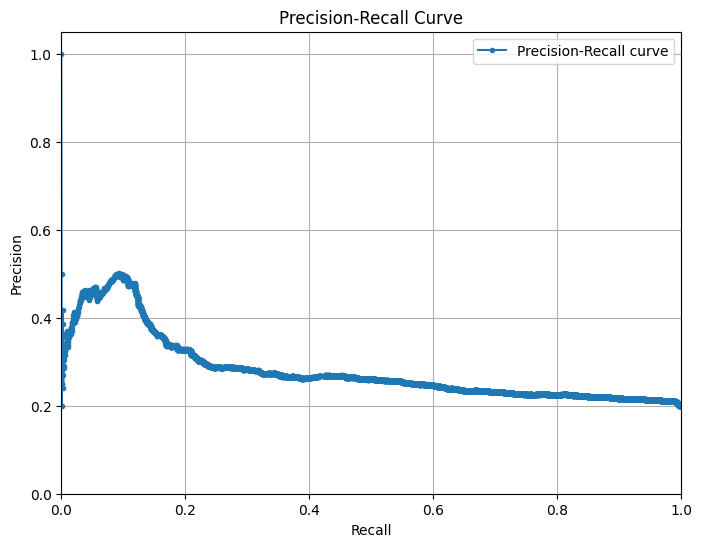

In [223]:
#Running the training loop
w,b,train_losses,val_losses = logreg(x_train,y_train,x_test,y_test,eta=0.01,epochs=150,lamda=1)

#Plotting losses
plot(train_losses,val_losses)

#Evaluating on val data
evaluate_model(x_test, y_test, w, b)


SGD for the logistic regression function did not show a decrease in train and val losses as the weight updates were negligible considering one example at a time. However, a full batch gradient descent performed decently given the complexity of the dataset on the same data.

Precision signifies how many of the predicted positives were true positives whereas Recall signifies how well the model identifies actual positives. A low precision score signifies a high rate of false positives whereas a low recall score signifies that the model predicts a large number of true positives as negatives. 
The tradeoff between precision and recall occurs in the following two cases:
1. High Precision and low Recall : all predicted positives are true positives but a huge chunk of true positives are predicted as negatives.
2. High Recall and low Precision : large number of predicted positives but many among those are true negatives.